## Final Project Submission

Please fill out:
* Student name: Tiffany Cheruto
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Asha Deen
* Blog post URL:


### BUSINESS UNDERSTANDING 

The movie industry generates a huge volume of content every year, but not all movies perform the same in terms of
quality and popularity. Platforms like imdb capture ratings (how much people liked a movie), while
tmdb captures popularity (attention over time).

The main objective is to answer the following key business questions:

1. **Are popular movies also highly rated?**  
   Understanding the relationship between popularity and quality helps studios and streaming platforms know if 
   marketing-driven hype leads to critically good movies or just temporary attention.

2. **What trends can we observe over time?**  
   Tracking how ratings and popularity evolve over the years can help predict audience behavior, content planning, 
   and highlight shifts in audience taste.

3. **Which genres dominate the movie industry?**  
   By analyzing genres, we can find which genres:
   - Are most popular among viewers
   - Maintain consistently high ratings
   - have high quality

Ultimately, these insights help decision-makers (producers and marketers) align investments with 
both **audience demand** and **trends**.


### DATA UNDERSTANDING

Here, i used **imdb(sqlite)**
       - movie_basics: movie_id, primary_title, start_year, genres.
       - movie_ratings: movie_id, averagerating, numvotes.
             **tmdb(excel)**
       - genre_id, original_title, popularity, release_date, vote_average, vote_count.

- Previewed the data in both sources to understand column names and records.
- Checked for **row counts, duplicates, missing values**, and the general structure of the datasets.

i chose this two because **imdb provides ratings** and **tmdb provides popularity metrics**, allowing us to analyze the relationship between them.


Before we start cleaning and analyzing the data, we need to:
1. Connect to the `im.db` SQLite database.
2. List all tables in the database.
3. Preview the first 5 rows of each table to:
   - Understand the structure of the data
   - See the column names and data types
   - Identify missing values 

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
np.random.seed(0) #set a random seed for reproducibility
import sqlite3

In [197]:
#connect to a database
conn = sqlite3.connect(r"C:\Users\USER\Documents\phase 2 project\dsc-phase-2-project-v3\zippedData\im.db\im.db")

#list all tables
tables = conn.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()
for t in tables:
    print(t[0])

movie_basics
directors
known_for
movie_akas
movie_ratings
persons
principals
writers
tmdb.movies
tmdb_movies


Before we start cleaning and analyzing the data, we need to:
1. Connect to the `im.db` SQLite database.
2. List all tables in the database.
3. Preview the first 5 rows of each table to:
   - Understand the structure of the data
   - See the column names and data types
   - Identify missing values and inconsistencies

In [198]:
# Loop through tables
for t in tables:
    table_name = t[0]
    print(f"\n--- {table_name} ---")
    
    # Read 5 rows into a dataframe
    query = f"SELECT * FROM {table_name} LIMIT 5;"
    df_preview = pd.read_sql_query(query, conn)
    
    # Print the preview
    print(df_preview)


--- movie_basics ---
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  

--- directors ---
    movie_id  person_id
0  tt0285252  nm0899854
1  tt0462036  nm1940585
2  tt0835418  nm0151540
3  tt0835418  nm0151540
4  tt0878654  nm0089502

--- known_for ---
   

DatabaseError: Execution failed on sql 'SELECT * FROM tmdb.movies LIMIT 5;': no such table: tmdb.movies

In [ ]:
# Count rows for each table
for t in tables:
    table_name = t[0]
    count = conn.execute(f"SELECT COUNT(*) FROM {table_name};").fetchone()[0]
    print(f"{table_name}: {count:,} rows")


movie_basics: 146,144 rows
directors: 291,174 rows
known_for: 1,638,260 rows
movie_akas: 331,703 rows
movie_ratings: 73,856 rows
persons: 606,648 rows
principals: 1,028,186 rows
writers: 255,873 rows


Now that we've Connected to the `im.db` SQLite database, Listed all tables in the database and Previewed the first 5 rows of each table, we can now start cleaning the column names and data types.
1. Handle Missing Values
   - Replace `\N` and empty strings with proper `NaN`.
2. Correct Data Types
   - Convert numeric columns (e.g., ratings, years, votes, popularity) 
     from text to numbers.
   - Parse dates (e.g., `release_date`) into datetime format.
3. Remove Duplicates 
   - Drop any duplicate rows that may exist.
4. Prepare for Analysis
   - Add useful derived columns (like `year` from `release_date`) 
     and ensure that we stick to formating it

In [ ]:
def load_and_clean_table(table_name, conn):
    # Load table
    df = pd.read_sql_query(f"SELECT * FROM {table_name};", conn)

    # Replace \N and empty strings with NaN
    df.replace(['\\N', ''], np.nan, inplace=True)

    # Drop duplicate rows if any to ensure that every row has a unique record
    df.drop_duplicates(inplace=True)

    return df


Use errors='coerce' to tell pandas how to handle invalid values

In [ ]:
tables_cleaned = {}

for t in tables:
    table_name = t[0]
    print(f"Cleaning table: {table_name}")
    df = load_and_clean_table(table_name, conn)

    # Specific fixes based on table
    if table_name == 'movie_basics':
        # convert year and runtime
        df['start_year'] = pd.to_numeric(df['start_year'], errors='coerce')
        df['runtime_minutes'] = pd.to_numeric(df['runtime_minutes'], errors='coerce')

    if table_name == 'movie_ratings':
        df['averagerating'] = pd.to_numeric(df['averagerating'], errors='coerce')
        df['numvotes'] = pd.to_numeric(df['numvotes'], errors='coerce')

    if table_name == 'tmdb_movies':
        # Parse release_date: keeping them as strings limits what i can do with them since they're usually stored as a string
        # Add a year column to simplify grouping and reduce complexity for grouping.
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
        df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
        df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
        df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
        df['year'] = df['release_date'].dt.year

    # Save cleaned DataFrame
    tables_cleaned[table_name] = df


Cleaning table: movie_basics
Cleaning table: directors
Cleaning table: known_for
Cleaning table: movie_akas
Cleaning table: movie_ratings
Cleaning table: persons
Cleaning table: principals
Cleaning table: writers


Let's check on the cleaned data to ensure that our data was actually cleaned, nothing was accidentally deleted.

In [ ]:
#check cleaned data
for name, df in tables_cleaned.items():
    print(f"{name}: {df.shape[0]:,} rows, {df.shape[1]} columns")


movie_basics: 146,144 rows, 6 columns
directors: 163,535 rows, 2 columns
known_for: 1,638,260 rows, 2 columns
movie_akas: 331,703 rows, 8 columns
movie_ratings: 73,856 rows, 3 columns
persons: 606,648 rows, 5 columns
principals: 1,028,186 rows, 6 columns
writers: 178,352 rows, 2 columns


## CLEANING THE EXCEL DATASET ##

Load the dataset and then the next step is to ensure it is clean and ready for analysis.

We must ensure that we:
1. Handle Missing Values
   - Replace `\N` or empty strings with `NaN`.
   - Confirm if there are any actual missing values.
2. Ensure Correct Data Types
   - Convert numeric columns like `popularity`, `vote_average`, and `vote_count`.
   - Convert `release_date` into a datetime format and extract the `year`.
3. Remove Duplicates
   - Drop any duplicate rows to ensure unique records.
4. Verify Data Quality
   - After cleaning, we will check the shape, data types, and missing value counts to confirm that the dataset is ready for analysis.




In [ ]:

# Load your Excel file
df = pd.read_csv(r"C:\Users\USER\Documents\phase 2 project\dsc-phase-2-project-v3\zippedData\tmdb.movies.csv\tmdb.movies.csv")

# Quick preview
print(df.head()) #first 5 rows



   Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   
2           2        [12, 28, 878]  10138                en   
3           3      [16, 35, 10751]    862                en   
4           4        [28, 878, 12]  27205                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   
2                                    Iron Man 2      28.515   2010-05-07   
3                                     Toy Story      28.005   1995-11-22   
4                                     Inception      27.920   2010-07-16   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1           

In [ ]:
#size of the dataset
print(df.shape)

(26517, 10)


In [ ]:
#data types for all the columns and null values
df.info

<bound method DataFrame.info of        Unnamed: 0            genre_ids      id original_language  \
0               0      [12, 14, 10751]   12444                en   
1               1  [14, 12, 16, 10751]   10191                en   
2               2        [12, 28, 878]   10138                en   
3               3      [16, 35, 10751]     862                en   
4               4        [28, 878, 12]   27205                en   
...           ...                  ...     ...               ...   
26512       26512             [27, 18]  488143                en   
26513       26513             [18, 53]  485975                en   
26514       26514         [14, 28, 12]  381231                en   
26515       26515      [10751, 12, 28]  366854                en   
26516       26516             [53, 27]  309885                en   

                                     original_title  popularity release_date  \
0      Harry Potter and the Deathly Hallows: Part 1      33.533   2010-

In [ ]:
# Replace \N and blanks with NaN
df.replace(['\\N', ''], np.nan, inplace=True)
# Drop duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Fix numeric columns
for col in ['popularity', 'vote_average', 'vote_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fix release_date if present
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['year'] = df['release_date'].dt.year
    print(df.shape)

(26517, 11)


We have to confirm if there are any rows with any missing values to avoid any duplicates

In [ ]:
#count missing values
df.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
year                 0
dtype: int64

In [ ]:
conn = sqlite3.connect(r"C:\Users\USER\Documents\phase 2 project\dsc-phase-2-project-v3\zippedData\im.db\im.db")

# Save your cleaned Excel DataFrame to the database
df.to_sql('tmdb_movies', conn, if_exists='replace', index=False)


26517

In [ ]:
# Check all table names
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print([t[0] for t in tables])


['movie_basics', 'directors', 'known_for', 'movie_akas', 'movie_ratings', 'persons', 'principals', 'writers', 'tmdb.movies', 'tmdb_movies']


### DATA MERGING ###

In this step, we perform a comprehensive join to bring together data from four sources into a single dataset:

1. imdb – `movie_basics`
   years, and genres.

2. imdb – `movie_ratings` 
   Provides IMDb ratings (`averagerating`) and vote counts (`numvotes`).

3. tmdb – `tmdb_movies`
   Provides popularity, TMDb ratings (`vote_average`), vote counts, and genre IDs.

4. imdb – `principals`
   Links each movie to its people (actors, directors, writers, etc.) through `person_id` and `category`.


- Join `movie_basics` with `movie_ratings` using `movie_id`.
- Join the result with `tmdb_movies` using `primary_title` + `start_year` = `original_title` + `year`.
- Finally, perform a LEFT JOIN with `principals` on `movie_id` so that all movies are retained even if no associated people are present.

WHY: 
This combined dataset allows us to:
- Analyze correlations between popularity and ratings,
- Explore patterns and trends over time,
- And later investigate how directors, actors, or writers may influence a movie’s success.


Let us verify that the data is loaded correctly by previewing. This is to:
-Ensure that movie_basics, movie_ratings, and tmdb_movies and principals exist in the database.
-Confirm that the import from Excel to SQLite worked as expected.

In [ ]:
# Preview 5 rows of movie_basics
print(pd.read_sql_query("SELECT * FROM movie_basics LIMIT 5;", conn).head())

# Preview 5 rows of movie_ratings
print(pd.read_sql_query("SELECT * FROM movie_ratings LIMIT 5;", conn).head())

# Preview 5 rows of tmdb_movies
print(pd.read_sql_query("SELECT * FROM tmdb_movies LIMIT 5;", conn).head())

#Preview 5 rows of principals
print(pd.read_sql_query("SELECT * FROM principals LIMIT 5;",conn).head())


    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  
     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726            4.2     50352
4   tt106024

Lets input a code to show all the available columns in each table so as to help us while merging tables together.

In [ ]:
# Function to show all column names of a table
def show_columns(table):
    cols = conn.execute(f"PRAGMA table_info({table});").fetchall()
    print(f"Columns in {table}:")
    for c in cols:
        print(" -", c[1])

# Check columns
show_columns("movie_basics")
show_columns("movie_ratings")
show_columns("tmdb_movies")
show_columns("principals")

Columns in movie_basics:
 - movie_id
 - primary_title
 - original_title
 - start_year
 - runtime_minutes
 - genres
Columns in movie_ratings:
 - movie_id
 - averagerating
 - numvotes
Columns in tmdb_movies:
 - Unnamed: 0
 - genre_ids
 - id
 - original_language
 - original_title
 - popularity
 - release_date
 - title
 - vote_average
 - vote_count
 - year
Columns in principals:
 - movie_id
 - ordering
 - person_id
 - category
 - job
 - characters


In [ ]:
query = """
SELECT b.primary_title,b.start_year,r.averagerating,t.popularity,t.vote_average, p.person_id, p.category
FROM movie_basics AS b
JOIN movie_ratings AS r
    ON b.movie_id = r.movie_id
JOIN tmdb_movies AS t
    ON b.primary_title = t.original_title AND b.start_year = t.year
LEFT JOIN principals AS p
    ON b.movie_id = p.movie_id;
"""

merged_basic = pd.read_sql_query(query, conn)
print("Rows in basic merge:", merged_basic.shape)
merged_basic.head()


Rows in basic merge: (106976, 7)


,primary_title,start_year,averagerating,popularity,vote_average,person_id,category
0,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0000080,director
1,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0000953,actor
2,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0001379,actor
3,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0001782,actress
4,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0004372,cinematographer


In [ ]:
merged_basic.info

<bound method DataFrame.info of                      primary_title  start_year  averagerating  popularity  \
0       The Other Side of the Wind        2018            6.9         9.8   
1       The Other Side of the Wind        2018            6.9         9.8   
2       The Other Side of the Wind        2018            6.9         9.8   
3       The Other Side of the Wind        2018            6.9         9.8   
4       The Other Side of the Wind        2018            6.9         9.8   
...                            ...         ...            ...         ...   
106971                   Albatross        2017            8.5         0.6   
106972                   Albatross        2017            8.5         0.6   
106973                   Albatross        2017            8.5         0.6   
106974                   Albatross        2017            8.5         0.6   
106975                   Albatross        2017            8.5         0.6   

        vote_average  person_id         cat

In [ ]:
merged_basic.head(10)

,primary_title,start_year,averagerating,popularity,vote_average,person_id,category
0,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0000080,director
1,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0000953,actor
2,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0001379,actor
3,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0001782,actress
4,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0004372,cinematographer
5,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0006166,composer
6,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0462648,actress
7,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0550881,producer
8,The Other Side of the Wind,2018,6.9,9.8,7.0,nm0613657,editor
9,The Other Side of the Wind,2018,6.9,9.8,7.0,nm1475059,producer


Next step is to clean the merged dataset to avoid any duplicate and any unnecessary spaces. 
We will have to drop 'person_id' and 'category' since duplicates appear after joining principals,
lets name the name table 'merged_unique'

In [ ]:
# Drop duplicates
merged_unique = merged_basic.drop(columns=['person_id','category']).drop_duplicates()
merged_unique.head(10)


,primary_title,start_year,averagerating,popularity,vote_average
0,The Other Side of the Wind,2018,6.9,9.800,7.0
10,Heaven & Hell,2018,4.0,0.600,7.5
20,Return to Babylon,2013,5.9,0.877,7.0
30,In My Sleep,2010,5.5,1.795,5.4
40,Bunyan and Babe,2017,5.0,2.051,6.2
50,On the Road,2012,6.1,8.919,5.6
60,The Secret Life of Walter Mitty,2013,7.3,10.743,7.1
70,Fahrenheit 451,2018,4.9,11.657,5.4
80,Nappily Ever After,2018,6.4,12.057,7.3
90,A Walk Among the Tombstones,2014,6.5,19.373,6.3


In [ ]:
#count missing values
merged_unique.isna().sum()

primary_title    0
start_year       0
averagerating    0
popularity       0
vote_average     0
dtype: int64

Lets check if a movie's 'tmdb vote' average is more closely related to its 'tmdb popularity'.
This plot helps answer:
- Do movies with higher ratings on tmdb also receive higher popularity on the same platform?
- Or is popularity largely independent of ratings?

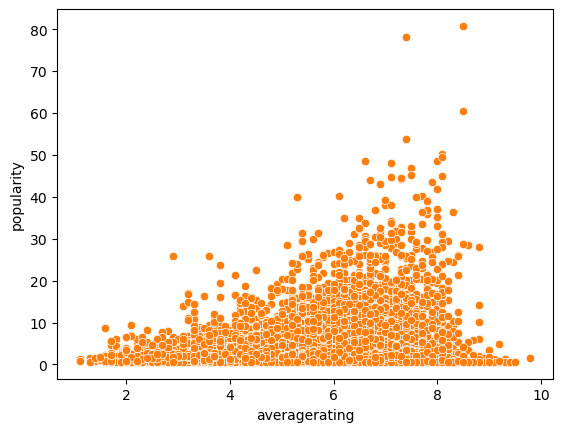

In [ ]:
#relationship between averagerating and popularity

sns.scatterplot(x='averagerating',y='popularity',data=merged_unique)
plt.show()

Low ratings (1–5):
Movies with very low ratings mostly have low popularity (clustered near the bottom left).

Medium ratings (5–8):
Most movies fall in this range.
Popularity values vary a lot here – some are very popular, others not.

High ratings (8+):
Movies with very high ratings are often popular, with some outliers reaching very high popularity scores.

Outliers:
There are a few movies with extremely high popularity above 60 that stand out.

Overall trend:
There is a slight upward trend: as IMDb ratings increase, popularity tends to be higher.
However, it’s not a perfect straight line – there is a lot of spread.



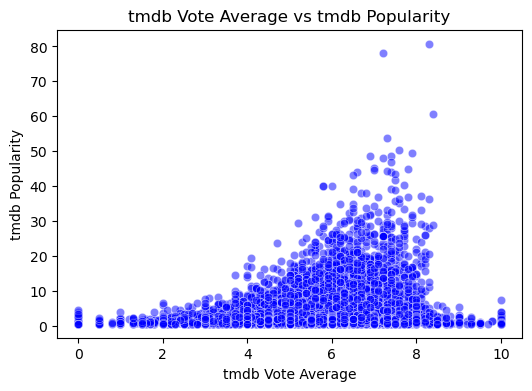

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=merged_unique,
    x='vote_average',
    y='popularity',
    color='blue',
    alpha=0.5
)
plt.title("tmdb Vote Average vs tmdb Popularity")
plt.xlabel("tmdb Vote Average")
plt.ylabel("tmdb Popularity")
plt.show()


Similar to the imdb scatterplot, there’s a slight upward pattern, movies with higher tmdb ratings tend to be more popular.
Outliers: -A few movies with very high popularity (> 60) stand out.
          -Some movies with very low vote averages (0–2) have low popularity.
Comparison with imdb vs Popularity:
The pattern is very similar. This suggests: Popularity is not strongly driven by ratings even on tmdb.
Other factors like marketing strongly influence popularity





### Key Finding: Popularity vs Ratings

Movies that are more popular tend to have slightly higher ratings.  
However, 
The relationship is weak, many popular movies have only average ratings, and some highly rated movies are not very popular.


### TRENDS OVER TIME ###

In this step, we examine how **average imdb ratings** and **average imdb popularity** 
have changed over time. To help us answer questions such as:

- Do recent movies tend to be more or less popular?
- Are movie ratings improving or declining with time?


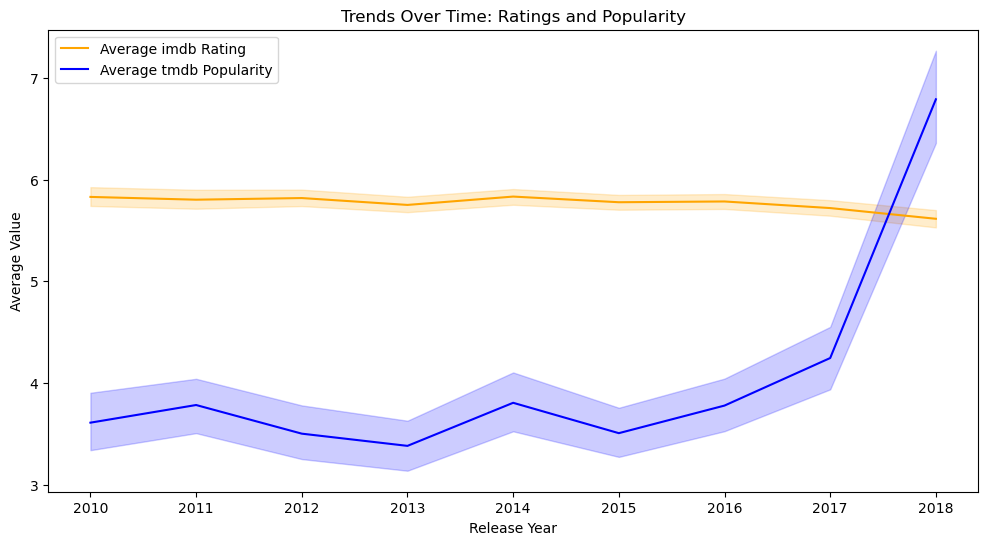

In [ ]:
plt.figure(figsize=(12,6))

sns.lineplot(data=merged_unique, x='start_year', y='averagerating', label='Average imdb Rating', color='orange')
sns.lineplot(data=merged_unique, x='start_year', y='popularity', label='Average tmdb Popularity', color='blue')

plt.title("Trends Over Time: Ratings and Popularity")
plt.xlabel("Release Year")
plt.ylabel("Average Value")
plt.legend()
plt.show()

This line chart compares how 'average imdbb ratings' and 'average tmdb popularity'
have changed from 2010 to 2018:

- **imdb Ratings (orange line):** Stay stable over time, around 5.7–6.0.
- **tmdb Popularity (blue line):** Shows more fluctuation and a steep rise in recent years.

**Key Insight:**  
While ratings remain constant, popularity has risen sharply in recent years,
indicating that popularity is influenced by new releases and marketing rather than quality alone.


In [ ]:
# lets Make sure the column exists
print(merged_unique.columns)

Index(['primary_title', 'start_year', 'averagerating', 'popularity',
       'vote_average'],
      dtype='object')


### GENRE ANALYSIS ###
lets run a merge to include the genre column for genre analysis

In [ ]:
query = """
SELECT b.primary_title, b.start_year, b.genres, r.averagerating, t.popularity, t.vote_average
FROM movie_basics AS b
JOIN movie_ratings AS r
    ON b.movie_id = r.movie_id
JOIN tmdb_movies AS t
    ON b.primary_title = t.original_title
       AND b.start_year = t.year;
"""

merged_unique = pd.read_sql_query(query, conn)
print("Rows in unique merge:", merged_unique.shape)
merged_unique.head()



Rows in unique merge: (11646, 6)


,primary_title,start_year,genres,averagerating,popularity,vote_average
0,The Other Side of the Wind,2018,Drama,6.9,9.800,7.0
1,Heaven & Hell,2018,Drama,4.0,0.600,7.5
2,Return to Babylon,2013,"Biography,Comedy,Drama",5.9,0.877,7.0
3,In My Sleep,2010,"Drama,Mystery,Thriller",5.5,1.795,5.4
4,Bunyan and Babe,2017,"Adventure,Animation,Comedy",5.0,2.051,6.2


We want to analyze genres.
The genres column often looks like this for a single row:
Action,Adventure,Sci-Fi meaning that this one movie belongs to multiple genres.
To count or average values per genre, we need one row per genre.
.str.split(',') turns "Action,Adventure" into ['Action', 'Adventure'].
.explode('genres') takes those lists and creates a new row for each genre. i did this because genre analysis only makes sense if each row corresponds to one genre.



In [ ]:
# Split the genres column into lists and expand into separate rows
genres_exploded = merged_unique.assign(genre=merged_unique['genres'].str.split(',').explode('genres'))

# Remove any missing/blank values
genres_exploded = genres_exploded.dropna(subset=['genres'])
genres_exploded['genres'] = genres_exploded['genres'].str.strip()  # clean spaces

# Count movies per genre
genre_counts = genres_exploded['genres'].value_counts().reset_index()
genre_counts.columns = ['genres', 'count']

genre_counts.head(10)


,genres,count
0,Documentary,1225
1,Drama,960
2,Comedy,565
3,Horror,557
4,"Comedy,Drama",369
5,"Horror,Thriller",367
6,"Comedy,Drama,Romance",282
7,Thriller,268
8,"Drama,Romance",238
9,"Drama,Thriller",212


In [ ]:
query = """
SELECT b.genres, COUNT(*) AS movie_count,
    AVG(r.averagerating) AS avg_rating,
    AVG(t.popularity) AS avg_popularity
FROM movie_basics AS b
JOIN movie_ratings AS r 
    ON b.movie_id = r.movie_id
JOIN tmdb_movies AS t
    ON b.primary_title = t.original_title
       AND b.start_year = t.year
GROUP BY b.genres
ORDER BY movie_count DESC
LIMIT 10;
"""
genre_sql = pd.read_sql_query(query, conn)
genre_sql


,genres,movie_count,avg_rating,avg_popularity
0,Documentary,1225,6.989959,1.511583
1,Drama,960,6.051458,2.488955
2,Comedy,565,5.312212,3.305742
3,Horror,557,4.173788,2.163386
4,"Comedy,Drama",369,6.038211,4.125420
5,"Horror,Thriller",367,4.359128,3.624905
6,"Comedy,Drama,Romance",282,5.973759,4.549890
7,Thriller,268,4.685821,2.103377
8,"Drama,Romance",238,6.149580,4.883340
9,"Drama,Thriller",212,5.499057,3.853500


In [ ]:
print(genre_sql.columns)

Index(['genres', 'movie_count', 'avg_rating', 'avg_popularity'], dtype='object')


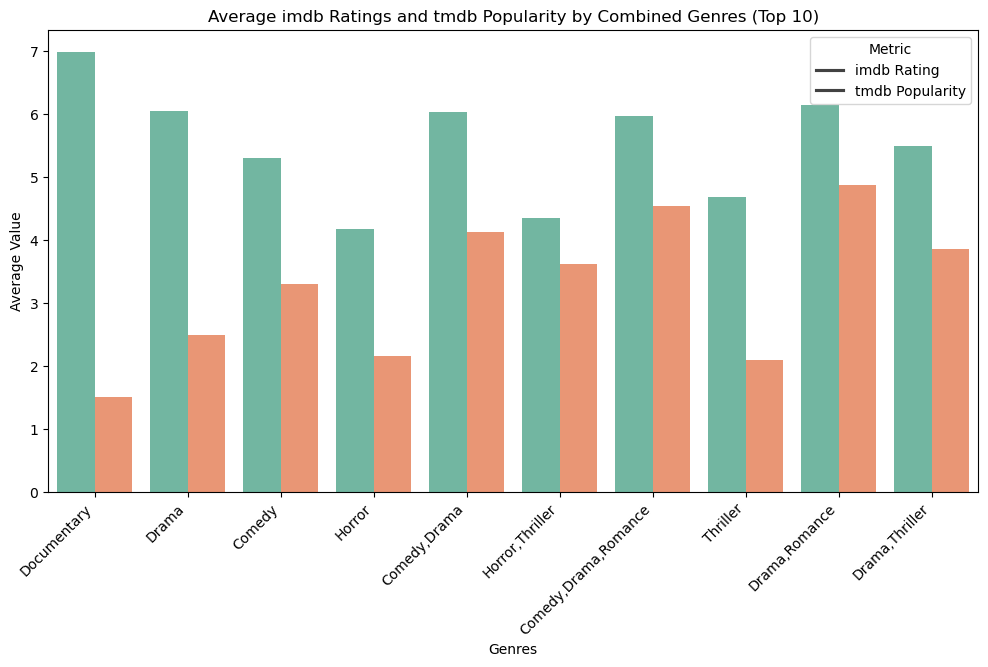

In [ ]:
# Reshape for plotting
genre_sql= genre_sql.melt(
    id_vars='genres',
    value_vars=['avg_rating', 'avg_popularity'],
    var_name='metric',
    value_name='value'
)

plt.figure(figsize=(12,6))
sns.barplot(data=genre_sql,
            x='genres', y='value', hue='metric', palette='Set2', color = 'green')
sns.barplot(data=genre_sql,          
            x='genres', y='value', hue='metric', palette='Set2', color='orange')
plt.title("Average imdb Ratings and tmdb Popularity by Combined Genres (Top 10)")
plt.xlabel("Genres")
plt.ylabel("Average Value")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric", labels=["imdb Rating", "tmdb Popularity"])
plt.show()


### Insights

From the combined visualization of **average ratings and popularity**:

1. **Top genres by popularity:**  
   - The genres with the highest average popularity are: comedy drama, Comedy drama romance, drama romance.

2. **Top genres by ratings:**  
   - The genres with the highest average IMDb ratings are: documentary, drama, comedy.

3. **Balance between quality and hype:**  
   - Genres like comedy drama and comedy drama romance show high popularity but relatively low ratings.
   - Genres like documentary are highly rated but not very popular.

4. **Impact of movie count:**  
   - Some genres with high averages like documentarary have **fewer movies**.
   - Others with **many movies** like drama, dominate the dataset.

**Conclusion:**  
These results suggest that popularity does not always align with quality.  
For deeper insights we should maybe explore **individual genre and time trends**
